# Web Scraping - Stock Market Sentiment

## Objectives

1. Obtain financial news as text

2. Visualize sentiment scores of the company

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [1]:
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Web Scraping

In [2]:
web_url = 'https://finviz.com/quote.ashx?t='

In [3]:
news_tables = {}
tickers = ['EBAY']

for tick in tickers:
    url = web_url + tick
    req = Request(url=url, headers={'user-agent': 'Chrome'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html')
    news_table = html.find(id="news-table")
    news_tables[tick] = news_table

In [4]:
parsed_data = []

for tick, news_table in news_tables.items():
    for row in news_table.findAll("tr"):
        title = row.a.get_text()
        date_data = row.td.text.split(' ')
        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        parsed_data.append([tick, date, time, title])

In [11]:
df = pd.DataFrame(parsed_data, columns=['Ticker','Date','Time','Title'])
df.head()

,Ticker,Date,Time,Title
0,EBAY,Apr-01-22,05:14AM,Top Stocks for April 2022
1,EBAY,Mar-31-22,06:30AM,PayPal Stock: Bull vs. Bear
2,EBAY,Mar-30-22,05:37PM,eBay CEO: 'Deeply' Considering Adding Crypto f...
3,EBAY,Mar-28-22,04:16PM,Amazon Stock Rally Picks Up to Erase Losses fo...
4,EBAY,Mar-26-22,08:25AM,Lofty Valuations and Inflation: Why eBay Might...


In [15]:
df

,Ticker,Date,Time,Title
0,EBAY,Apr-01-22,05:14AM,top stocks april 2022
1,EBAY,Mar-31-22,06:30AM,paypal stock bull vs bear
2,EBAY,Mar-30-22,05:37PM,ebay ceo deeply considering adding crypto paym...
3,EBAY,Mar-28-22,04:16PM,amazon stock rally picks erase losses year
4,EBAY,Mar-26-22,08:25AM,lofty valuations inflation ebay might favorite...
...,...,...,...,...
95,EBAY,Feb-02-22,06:07PM,disappointing forecast revenue earnings user g...
96,EBAY,Feb-02-22,04:55PM,nike goes counterfeit resellers faults amazon ...
97,EBAY,Feb-02-22,12:00PM,paypal stock slides inflation concerns
98,EBAY,Feb-02-22,11:35AM,paypal stock buy


## Text Processing

In [12]:
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

In [13]:
# Lower casing and removing punctuations
df['Title'] = df['Title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Title'] = df['Title'].str.replace('[^\w\s]',"")
df['Title'].head()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13060/266332676.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Title'] = df['Title'].str.replace('[^\w\s]',"")


0                            top stocks for april 2022
1                            paypal stock bull vs bear
2    ebay ceo deeply considering adding crypto for ...
3    amazon stock rally picks up to erase losses fo...
4    lofty valuations and inflation why ebay might ...
Name: Title, dtype: object

In [14]:
# Removal of stop words
stop = set(stopwords.words('english'))
df['Title'] = df['Title'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
df['Title'].head()

0                                top stocks april 2022
1                            paypal stock bull vs bear
2    ebay ceo deeply considering adding crypto paym...
3           amazon stock rally picks erase losses year
4    lofty valuations inflation ebay might favorite...
Name: Title, dtype: object

In [9]:
# Spelling correction
df['Title'] = df['Title'].apply(lambda x: str(TextBlob(x).correct()))
df['Title'].head()

0                                top stocks april 2022
1                             papal stock bull vs bear
2      bay co deeply considering adding crept payments
3             amazon stock rally pick ease losses year
4    lofty valuation inflation bay might favorite s...
Name: Title, dtype: object

In [10]:
# Lemmatization
df['Title'] = df['Title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Title'].head()

0                                 top stock april 2022
1                              papal stock bull v bear
2       bay co deeply considering adding crept payment
3               amazon stock rally pick ease loss year
4    lofty valuation inflation bay might favorite s...
Name: Title, dtype: object

## Headline News Sentiment

In [16]:
vader = SentimentIntensityAnalyzer()
s = lambda title: vader.polarity_scores(title)['compound']

df['Compound'] = df['Title'].apply(s)
df.head()

,Ticker,Date,Time,Title,Compound
0,EBAY,Apr-01-22,05:14AM,top stocks april 2022,0.2023
1,EBAY,Mar-31-22,06:30AM,paypal stock bull vs bear,0.0000
2,EBAY,Mar-30-22,05:37PM,ebay ceo deeply considering adding crypto paym...,0.0000
3,EBAY,Mar-28-22,04:16PM,amazon stock rally picks erase losses year,-0.2500
4,EBAY,Mar-26-22,08:25AM,lofty valuations inflation ebay might favorite...,0.4588


In [17]:
# convert date type
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [18]:
df.dtypes

Ticker       object
Date         object
Time         object
Title        object
Compound    float64
dtype: object

In [23]:
# Convert scores into positive, neutral, and negetive sentiments using some threshold
df['Sentiment'] = 'Positive'
df.loc[df['Compound'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Compound'] < 0, 'Sentiment'] = 'Negative'

In [24]:
df

,Ticker,Date,Time,Title,Compound,Sentiment
0,EBAY,2022-04-01,05:14AM,top stocks april 2022,0.2023,Positive
1,EBAY,2022-03-31,06:30AM,paypal stock bull vs bear,0.0000,Neutral
2,EBAY,2022-03-30,05:37PM,ebay ceo deeply considering adding crypto paym...,0.0000,Neutral
3,EBAY,2022-03-28,04:16PM,amazon stock rally picks erase losses year,-0.2500,Negative
4,EBAY,2022-03-26,08:25AM,lofty valuations inflation ebay might favorite...,0.4588,Positive
...,...,...,...,...,...,...
95,EBAY,2022-02-02,06:07PM,disappointing forecast revenue earnings user g...,0.1531,Positive
96,EBAY,2022-02-02,04:55PM,nike goes counterfeit resellers faults amazon ...,-0.5267,Negative
97,EBAY,2022-02-02,12:00PM,paypal stock slides inflation concerns,0.0000,Neutral
98,EBAY,2022-02-02,11:35AM,paypal stock buy,0.0000,Neutral


<AxesSubplot:xlabel='Date'>

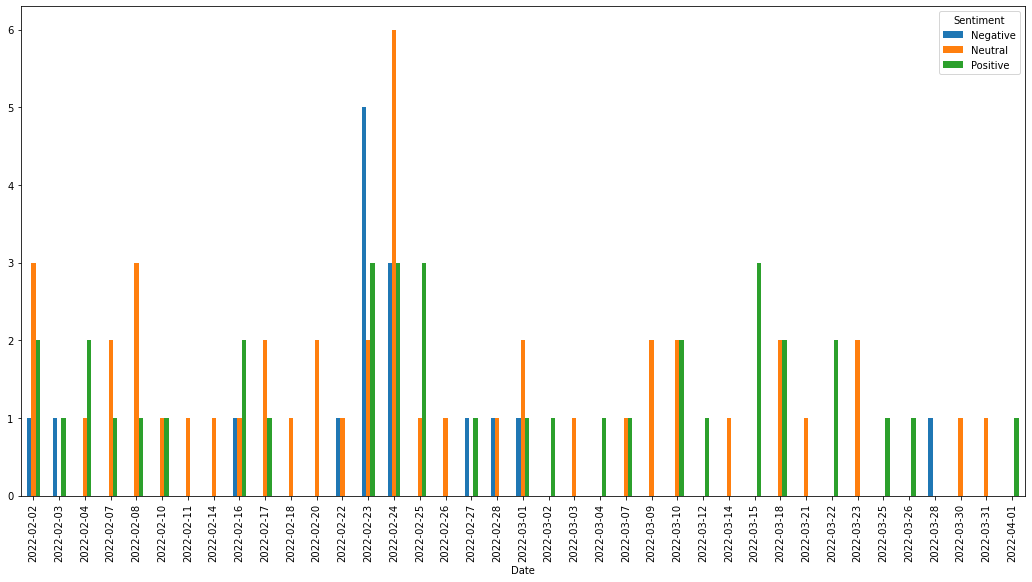

In [28]:
result=df.groupby('Date')['Sentiment'].value_counts().unstack()
result[['Negative','Neutral','Positive']].plot(kind='bar', figsize=(18,9))

In [108]:
Compound_Mean = df.groupby(['Date'], as_index=False)['Compound'].mean()
Compound_Mean.head()

,Date,Compound
0,2022-02-02,0.004717
1,2022-02-03,0.116200
2,2022-02-04,0.129000
3,2022-02-07,0.059300
4,2022-02-08,0.159225


In [118]:
Compound_Mean.dtypes

Date         object
Compound    float64
dtype: object

<AxesSubplot:xlabel='Date'>

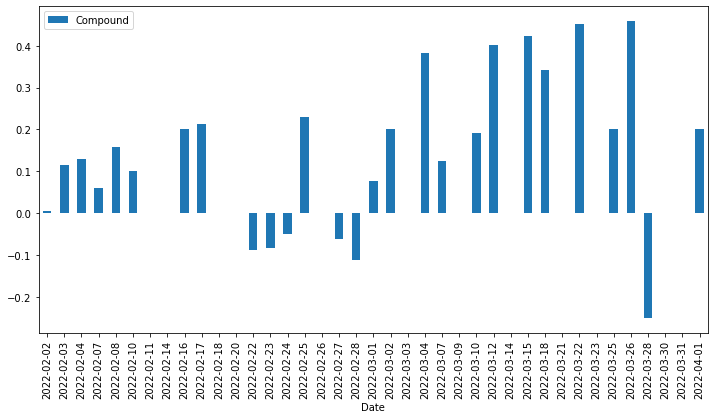

In [107]:
Compound_Mean.plot(kind='bar', x='Date', y='Compound',figsize=(12,6))

## Real Stock Data

In [43]:
import yfinance as yf

In [44]:
ebay = yf.Ticker("EBAY")
ebay_stock = ebay.history(
    start=('2022-02-03'),
    end=('2022-04-02'),
    interval='1d').reset_index()

In [45]:
ebay_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-02-02,60.220456,60.339959,57.183039,58.298420,8826200,0.00,0
1,2022-02-03,57.760646,57.850275,56.695062,56.953987,6287200,0.00,0
2,2022-02-04,57.103369,60.021278,57.013740,59.045322,10587000,0.00,0
3,2022-02-07,58.935779,59.483508,58.298420,58.457760,5718400,0.00,0
4,2022-02-08,58.198828,59.662763,58.198828,59.483505,3770700,0.00,0
5,2022-02-09,60.120863,60.409668,59.453630,60.359875,3448800,0.00,0
6,2022-02-10,59.244501,59.782269,58.238667,58.567307,3976200,0.00,0
7,2022-02-11,59.065242,59.692640,57.810440,58.139080,5897200,0.00,0
8,2022-02-14,58.288457,58.398004,57.441967,57.939903,5714500,0.00,0
9,2022-02-15,58.716684,59.742436,58.388048,59.682682,3803800,0.00,0


In [116]:
ebay_stock.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits             int64
dtype: object

In [70]:
ebay_close_price = ebay_stock[['Date', 'Close']]
ebay_close_price = pd.DataFrame(ebay_close_price)
ebay_close_price.head()

,Date,Close
0,2022-02-02,58.298420
1,2022-02-03,56.953987
2,2022-02-04,59.045322
3,2022-02-07,58.457760
4,2022-02-08,59.483505


In [124]:
ebay_close_price.dtypes

Date      object
Close    float64
dtype: object

In [123]:
ebay_close_price['Date'] = ebay_close_price['Date'].astype(str)

<AxesSubplot:xlabel='Date'>

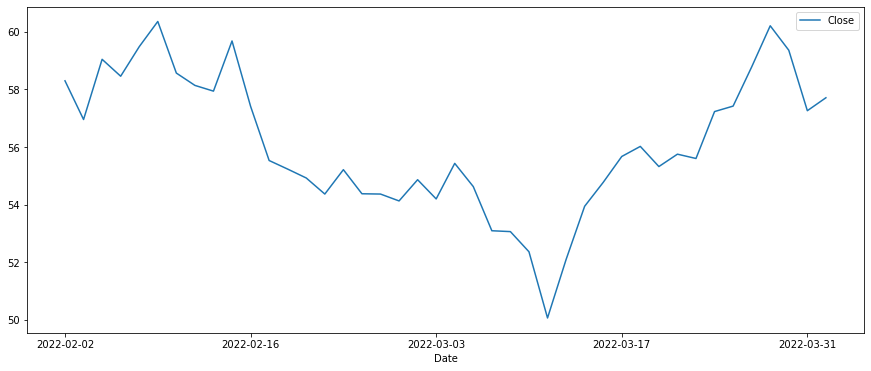

In [127]:
ebay_close_price.plot(kind='line', x='Date', y='Close',figsize=(15,6))